In [38]:
import pandas as pd
import pmdarima as pm
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import warnings

# Forecasting time series of US real estate sales data
In this section it is tried to build a model for predicting prices of real estate sales in the US.
The time series is generated by aggregating data of individual sales. 
The aim is to predict median (typical) prices on quarterly prediction interval.

### Useful functions collection

In [63]:
# defining font for labels and title for function "plot_time_series_forecast_with_error"
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

def plot_time_series_forecast_with_error(time_series, predicted_time_series, error_upper, error_lower,
                                         bound, title, alpha=0.9):
    """Function creates plot of time series and predicted_time_series (both DataFrame).
    error_upper and error_lower are serials defining error boundaries on forecast.
    bound defines integer index value, from where forecast period begins.
    title is string set as title of plot.
    alpha defines error interval for legend."""
    fig, ax = plt.subplots()
    # Plot original time series and its prediction
    ax.plot(time_series, color='black', label='time series')
    ax.plot(predicted_time_series, color='blue', label='one step ahead forecast')
    # Confidence interval plotting
    ax.fill_between(time_series.iloc[bound:].index, error_lower[bound:], error_upper[bound:], 
                    color='lightblue', label=f'{alpha:.0%} confidence interval')
    # Plot vertical line, which seperates training from forecasting period
    ax.vlines(time_series.index[bound], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='black', 
          linestyles='dashed', label='forecast period begin')
    
    # Labels and legends:
    ax.legend()
    ax.set_xlabel('Time / quarterly', fontdict=font)
    ax.set_ylabel('price / 1000 $', fontdict=font)
    ax.set_title(f'{title}', 
             fontdict=font)
    
def multistep_forecast_generator(time_series, bound, model_dict, alpha=0.9):
    """Function calculates multible timestep forecast for multible mpdarima.ARMIMA-models
    to fill the forecast from index position bound to end of time_series.
    Additionally error ranges are calculated.
    Returns: 
    (1) DataFrame with time_series and forecasts of models
    (2) List with all names of models that were added to DataFrame in (1). Note: Models that
        produce ConvergenceWarnings are excluded from output.
    time_series: Pandas-DataFrame with time series to fit and forecast.
    bound: integer index position seperating training data from forecast period.
    model_dict: Dictionary containing parameters for pmdarmima.ARIMA models.
    alpha: significance for error range of forecast."""
    warnings.simplefilter('error', UserWarning) # In order to manage ConvergenceWarnings of pmdarima
    time_series_train = time_series[:bound] # select training data set 
    no_forecast_steps = len(time_series) - bound # calculate how many multistep forecasts are neccessary
    df_ = pd.DataFrame(time_series).rename(columns=lambda s: 'time_series') #DataFrame, that will hold
    # initial time series and forecasts, as well as the forecasts errors
    used_models = [] # List that will hold all model names, that were forecasted and added to df_
    for i, (key, param) in enumerate(model_dict.items()): #iterate over all desired models
        try: 
            # Define mpdARIMA-model from parameters in model_dict and perform multistep forecasts
            pmdarima_model = pm.ARIMA(order=param[0], seasonal_order=param[1]).fit(time_series_train)
            series_forecast, conf_int = pmdarima_model.predict(no_forecast_steps, return_conf_int=True, 
                                                           alpha=(1-alpha))
            # Assign forecast and error of this model to DataFrame df_
            df_ = df_.assign(**{str(key): series_forecast, 
                         (str(key) + '_lower'): pd.Series(conf_int[:, 0], index=time_series.index[bound:]),
                         (str(key) + '_upper'): pd.Series(conf_int[:, 1], index=time_series.index[bound:])})
            # Write model name to list of used model names
            used_models.append(str(key))
        except:
            # If ConvergenceWarning occured: write which model is not used any longer
            print(f'ConvergenceWarning occured in {key}, model erased from table.')
        
    return df_, used_models
    
def rms(A, B):
    """Function accepts two same sized pandas Series to return the rms."""
    return np.sqrt(1/len(A)*np.sum((A - B)**2))

## Loading the data and building the time series

In [3]:
df_raw = pd.read_csv('raw_sales.csv') #Load data from csv-file

# Set up a ordered categorical datatype to handle no. of bedrooms
replace_dic={0: 'zero', 
             1: 'one',
             2: 'two',
             3: 'three',
             4: 'four',
             5: 'five'}
ordered_bedrooms = pd.Series(sorted(set(df_raw.bedrooms))).replace(replace_dic)
bedroom_type = pd.CategoricalDtype(categories=ordered_bedrooms, ordered=True)



def tweak_sales(df_):
    """Function convert dates to datetime-objects and pushes them into the index.
    Then, time series for prices of real estate on quarterly basis are build by grouping and aggregation."""
    return(df_.assign(quarter=lambda s: pd.to_datetime(s.datesold).dt.to_period('Q'), #create date of sale
                                                                                      #as DateTime-Object quarters
                      price=lambda s: s.price/1000) #Express all prices in thousands $
           .drop(['datesold', 'postcode', 'propertyType'], axis='columns') #Delete old datesold, propertyType 
                                                                           #and postal code column, 
                                                                           #focus on price information
           .groupby(by=['quarter', 'bedrooms']) #Grouping with numbers of bedrooms, as this is indicator of size 
                                             #of real estate object. Grouping by date-column to obtain quarterly
                                             #data
           .price.median() #Aggregate meadian of prices instead of mean of prices, to minimize effect of outliers
           .unstack()  #Unstack group-object to obtain DataFrame
           .set_axis(pd.Index(data=ordered_bedrooms, dtype=bedroom_type, name='bedrooms'), axis=1) #set CatDtype
           .drop('zero', axis='columns') #Exclude real estate with zero bedrooms, hardly any data of zero bedrooms
           .bfill() #Missing data occurs at the beginning of columns (up to two each column). These are filled
                    #with values occuring right after the period of missing values. Meaning to assume, that 
                    #median prices didn't change over the period of missing data.
           .to_timestamp(how='end')
           .asfreq(freq='Q-DEC')
           )


In [4]:
# Customizing raw data DataFrame
df = tweak_sales(df_raw)
# Splitting DataFrame in test and train DataFrame with fraction beeing the fraction of training data
fraction = 0.8
boundary = int(fraction * (df.index.size - 1))
df_train = df.iloc[:boundary]
df_test = df.iloc[boundary:]

## Goal is to invent different models for same series starting with three bedroom real estate price time series. Later all predictions gained will be averaged.

### Befor training models: investigate time series by plotting

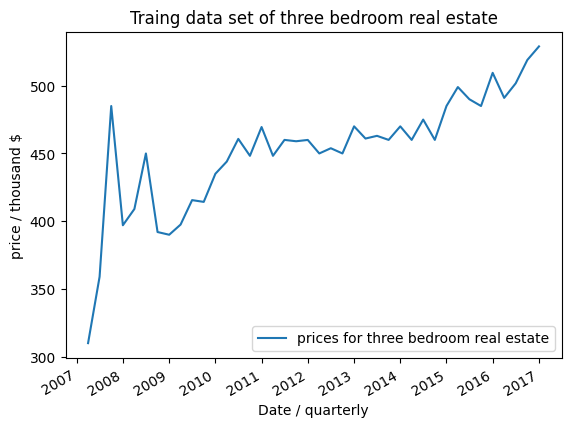

In [5]:
ax = df_train.three.plot(title='Traing data set of three bedroom real estate', legend=True)
ax.set(xlabel='Date / quarterly', ylabel='price / thousand $')
#ax.set_label(legend='prices for three bedroom real estate')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['prices for three bedroom real estate'], loc='lower right')


### Befor training: Investigate time series by STL decomposition


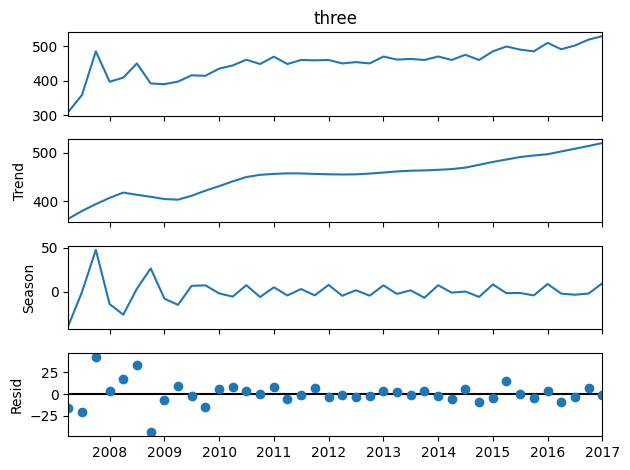

In [6]:
STL_result = STL(df_train.three, period=4, seasonal=7).fit()
fig = STL_result.plot()
# From the residuals it may be concluded, that variance was much greater within the years of 2008 and 2009.
# This would stay in contrast to desired stationarity. Applying APS test should clarify, if residuals are 
# staionary

In [7]:
# Calculating the ADF test to clarify if residuals are stationary
ADF_crit_value, ADF_p_value, _, _, crit_value_dict, _ = adfuller(STL_result.resid.values, maxlag=12, 
         regression='n') # 'n' for no constant or linear trend to include
# Print results of adjusted Dickey-Fuller-Test
print('Results of ADF-Test\np-value = ', ADF_p_value, '\nCritical values for test statistics are:')
for i, item in enumerate(crit_value_dict.items()):
    print('Critical value for '+item[0], ' ' * (12 - len(item[0])), ':', item[1])
print('Observerd test statistic value is:', ADF_crit_value)
print('\nNull-hypothesis is rejected and alternative, that Residuals are stationary and without unit root is accepted.')

Results of ADF-Test
p-value =  0.00011663481372058212 
Critical values for test statistics are:
Critical value for 1%            : -2.6416367741935485
Critical value for 5%            : -1.9521180087946024
Critical value for 10%           : -1.6102250015105233
Observerd test statistic value is: -3.8809179997266257

Null-hypothesis is rejected and alternative, that Residuals are stationary and without unit root is accepted.


[Text(0.5, 36.72222222222221, 'Lag order'),
 Text(510.4494949494949, 0.5, 'Partial auto correlation')]

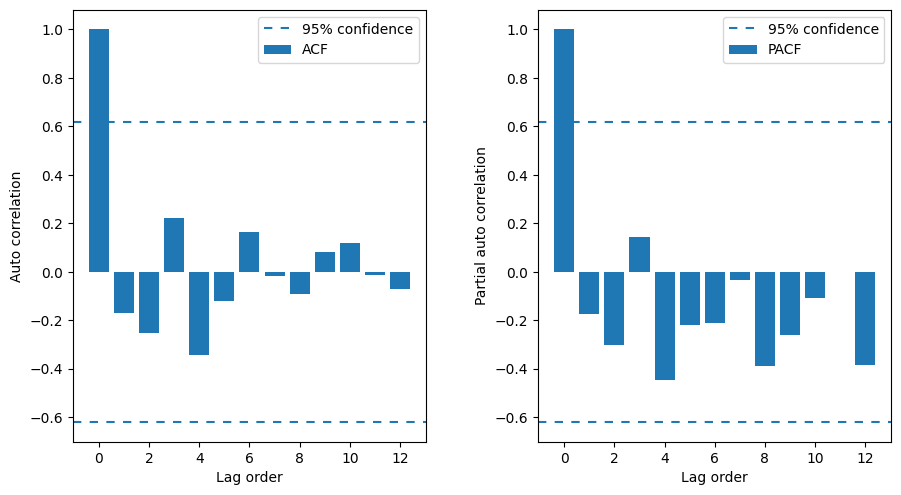

In [8]:
# As residuals are considered stationary, (partial) auto correlation function are plotted
# to facilitate model selection
# Calculating autocorrelation of residuals, defining 95% significance interval,
# qstat=True will provide test statistics for potential Ljung-Box-Test
acf_result, acf_intervals, q_statistics, p_values = acf(STL_result.resid, nlags=12, alpha=0.05, qstat=True)
    
# Calculating partial autocorrelation of residuals
pacf_result, pacf_intervals = pacf(STL_result.resid, nlags=12, alpha=0.05) #returns partial autocorrelation 
                                                                           #and confidence interval 
                                                                           #boundaries for 95 % 
    
# Confidence intervals for acf in this case are calculated from formular 1/sqrt(N-2)
acf_confidence = 1.96 * 1/np.sqrt(len(acf_result) - 3) # for 95% interval
# Calculate confidence interval from span of interval of last calculated itnerval
# Confidence interval is same for all lags > 0, it depends from nlags defined in pacf-function.
# Here we will plot confidence interal around 0, to measure, whether pacf of some lags significantly
# differ from 0.
pacf_confidence = abs(np.diff(pacf_intervals, axis=1)[-1][-1])


# Plotting (partial) autocorrelation
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
fig.tight_layout(pad=5)
axes[0].bar(np.arange(len(acf_result)), acf_result, label='ACF')
axes[0].axhline(-acf_confidence, dashes=(4, 4), label='95% confidence')
axes[0].axhline(acf_confidence, dashes=(4, 4))
axes[0].legend()
axes[0].set(xlabel='Lag order', ylabel='Auto correlation')
axes[1].bar(np.arange(len(pacf_result)), pacf_result, label='PACF')
axes[1].axhline(-pacf_confidence, dashes=(4, 4), label='95% confidence')
axes[1].axhline(pacf_confidence, dashes=(4, 4))
axes[1].legend()
axes[1].set(xlabel='Lag order', ylabel='Partial auto correlation')

There are no significant partial auto correlation or auto correlation contributions among the first 12 lags (so over a period of 3 years). This is to be considered, when chosing auto regressive or moving average models. To verify this, Ljung-Box test is calculated. Calculation from function statsmodels.tsa.stattools is not used, as degrees of freedom consumed by decomposition can't be set. Hypotheses of Ljung-Box-Test are:

H0: The data are independently distributed

H1: The data are not independently distributed; they exhibit serial correlation.

In [9]:
# Calculating Ljung-Box-Test with 1 degree of freedom consumend by decomposition (one period component)
Ljung_Box_result = (acorr_ljungbox(STL_result.resid, lags=12, model_df=1)
                    .reset_index() #Take Lags from index to new column
                    .rename(columns={'index': 'Lags', # Name column containing the lags "Lags"
                                     'lb_stat': 'Q-stat', # Name column containing test statistics "Q-stat"
                                     'lb_pvalue': 'p_value'}) # Name column containing p-values "p-values"
                    .assign(H0_reject=lambda s: s.p_value<0.05) # New column indicating where 
                                                                # H0 can be rejected
                   )
Ljung_Box_result

,Lags,Q-stat,p_value,H0_reject
0,1,1.234742,NaN,False
1,2,4.018030,0.045016,True
2,3,6.226677,0.044452,True
3,4,11.782745,0.008166,True
4,5,12.479692,0.014119,True
5,6,13.830793,0.016721,True
6,7,13.846015,0.031404,True
7,8,14.296097,0.046159,True
8,9,14.649871,0.066322,False
9,10,15.436476,0.079624,False


Interestingly for some lags H0 of Ljung-Box test can be rejected on an significance level of 5%. This may indicate, that models taking autocorrelation of residuals into account might be suitable, nontheless the values of acf and pacf where below the threshold. Models including autocorrelation should be compared to models who don't by information criteria in following section.

## 1. Model: STL forecast, using ARIMA to forecast deseasonalized series

STL-forecasting uses naive forecasting of seasonal component, trend component is modelled from a specified model, ARIMA in this case.

In [10]:
# Defining dictionary of argmuments passed to ARIMA model
ARIMA_args = {'order': (0, 1, 0), 'seasonal_order': (0, 0, 0, 0)}
# Creating instance of STLForecast, parameters like in decompositione example above. ARIMA model with 
# dictonary of arguments.
STL_naive = STLForecast(df_train.three, model=ARIMA, 
                              model_kwargs=ARIMA_args, period=4, seasonal=7)

# Fitting model to training data set
STL_naive_result = STL_naive.fit()
# Calculating multible time step forecast on test data set and prediction on training data set as whole
predict_all_series = STL_naive_result.get_prediction(start='2007', end='2020')
# Calculate prediction confidence interval for 90% for forecast period
conf_int_all_series = STL_naive_result.get_prediction(start=boundary, end='2020').conf_int(alpha=0.1)

In [11]:
# Fill results of prediction on training data, point forecast on test data,
# standard deviation and confidence interval on test data into same dataframe as time series data
df = df.assign(STL_ARIMA_three=predict_all_series.predicted_mean,
               STL_ARIMA_std_three=predict_all_series.se_mean,
               STL_ARIMA_90_lower=conf_int_all_series.lower,
               STL_ARIMA_90_upper=conf_int_all_series.upper)

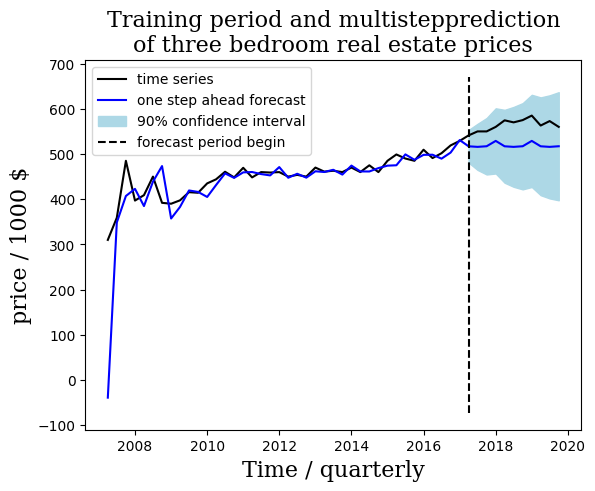

In [12]:
# Create plot of multistep ahead forecast
plot_time_series_forecast_with_error(df.three, df.STL_ARIMA_three,
                                     df.STL_ARIMA_90_upper, df.STL_ARIMA_90_lower,
                                     bound=boundary, title='Training period and multistep\
prediction\nof three bedroom real estate prices')

### Calculating a one step ahead prediction for whole test period
This is in contrast to the multistep forecast for the whole test period at once, seen before.

In [13]:
# List object / pd.Series obecjts to store one point ahead forecasts (mean, 90% confidence interval 
# boundaries) in. The are filled with predictions on training data and will appended by one point
# ahead forecasts later.

# Prediction values on training data period are the same already obtained from previous fit.
STL_ARIMA_onepoint_forecast = pd.Series(predict_all_series.predicted_mean[:boundary])
STL_ARIMA_onepoint_forecast_90_lower = pd.Series(dtype='float64')
STL_ARIMA_onepoint_forecast_90_upper = pd.Series(dtype='float64')

# Iterate over test period and take one step ahead forecast to memory
for i in range(df_test.index.size):
    # Define STL-ARIMA model as done for multistep forecast, except for expanding training data
    # period for one step in each iteration.
    STL_ARIMA_model_onepoint = STLForecast(df.iloc[:(boundary+i)].three, model=ARIMA, 
                              model_kwargs=ARIMA_args, period=4, seasonal=7)
    result = STL_ARIMA_model_onepoint.fit() #fit model for current time period
    
    # concatenate next value for predicted mean and lower/upper 90% boundaries
    STL_ARIMA_onepoint_forecast = pd.concat([STL_ARIMA_onepoint_forecast, 
              result.get_prediction(start=0, end=boundary+i).predicted_mean[[-1]]])
    STL_ARIMA_onepoint_forecast_90_lower = pd.concat([STL_ARIMA_onepoint_forecast_90_lower, 
               result.get_prediction(start=boundary, end=boundary+i).conf_int(alpha=0.1).lower[[-1]]])
    STL_ARIMA_onepoint_forecast_90_upper = pd.concat([STL_ARIMA_onepoint_forecast_90_upper, 
               result.get_prediction(start=boundary, end=boundary+i).conf_int(alpha=0.1).upper[[-1]]])

# Write constructed Series as columns to DataFrame df.
df = df.assign(STL_ARIMA_onepoint_pred_mean=STL_ARIMA_onepoint_forecast,
               STL_ARIMA_onepoint_90_lower=STL_ARIMA_onepoint_forecast_90_lower,
               STL_ARIMA_onepoint_90_upper=STL_ARIMA_onepoint_forecast_90_upper)

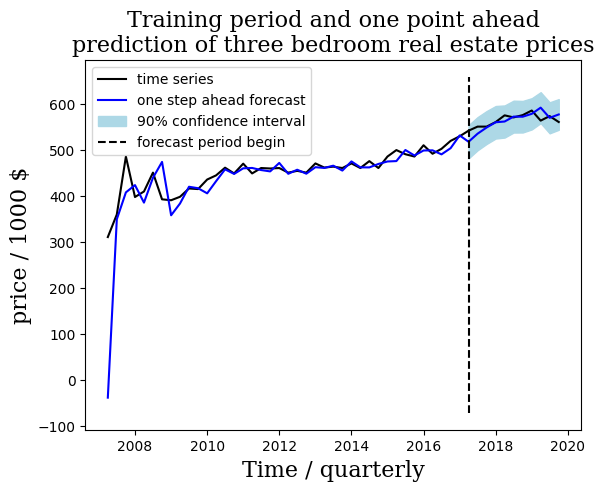

In [14]:
# Create plot of one step ahead forecast.
plot_time_series_forecast_with_error(df.three, df.STL_ARIMA_onepoint_pred_mean, 
                                     df.STL_ARIMA_onepoint_90_upper,
                                     df.STL_ARIMA_onepoint_90_lower,
                                     bound=boundary, 
                                     title='Training period and one point ahead\n\
prediction of three bedroom real estate prices'
                                     )

Calculating root-mean-squared-error (rms) on test data. Information criterions like AIC are designed to allow model selection on training data time series, as test data is often not available. Therefore, AIC penalizes in its calculation a rise in number of parameters of model, to prevent overfitting. 
In our case, test data set is available and allows comparison of models on simpler metrics like rms, as overfitting will be detected on a test data set.

In [32]:
STL_ARIMA_test_error = rms(df_test.three, df.STL_ARIMA_onepoint_pred_mean[boundary:])
print(f'RMS on test data of combined STL-ARIMA model is: {STL_ARIMA_test_error:.1f}')

RMS on test data of combined STL-ARIMA model is: 14.0


## 2. Model: (S)ARIMA model selected by pmdarima automatic detection

In [16]:
model_auto_arima = pm.auto_arima(df_train.three, start_p=0, start_d=0, start_q=0, test='adf', 
                                 stepwise=False, max_p=3, max_d=1, max_q=3, start_P=0,
                                 start_Q=0, max_P=2, max_D=1, max_Q=2, m=4, trace=True,
                                 information_criterion='aicc')

 ARIMA(0,1,0)(0,0,0)[4] intercept   : AICC=381.299, Time=0.04 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AICC=383.132, Time=0.14 sec
 ARIMA(0,1,0)(0,0,2)[4] intercept   : AICC=385.262, Time=0.15 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AICC=382.985, Time=0.08 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AICC=385.087, Time=0.17 sec
 ARIMA(0,1,0)(1,0,2)[4] intercept   : AICC=387.688, Time=0.25 sec
 ARIMA(0,1,0)(2,0,0)[4] intercept   : AICC=385.097, Time=0.10 sec
 ARIMA(0,1,0)(2,0,1)[4] intercept   : AICC=387.685, Time=0.61 sec
 ARIMA(0,1,0)(2,0,2)[4] intercept   : AICC=390.457, Time=0.32 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AICC=inf, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AICC=inf, Time=0.32 sec
 ARIMA(0,1,1)(0,0,2)[4] intercept   : AICC=inf, Time=0.61 sec
 ARIMA(0,1,1)(1,0,0)[4] intercept   : AICC=inf, Time=0.22 sec
 ARIMA(0,1,1)(1,0,1)[4] intercept   : AICC=inf, Time=0.29 sec
 ARIMA(0,1,1)(1,0,2)[4] intercept   : AICC=inf, Time=0.66 sec
 ARIMA(0,1,1)(2,0,0)[4] intercept 

In [64]:
# Chose 5 models with lowest AICc for further investigation and comparison
# Dictionary containing parameters of different ARIMA models
model_dict = {'model_0': [(2, 1, 0), (0, 0, 0, 0)],
              'model_1': [(2, 1, 0), (0, 0, 2, 4)],
              'model_2': [(2, 1, 0), (2, 0, 0, 4)],
              'model_3': [(2, 1, 0), (1, 0, 0, 4)],
              'model_4': [(2, 1, 0), (2, 0, 1, 4)]
             }
# Calculating multible step forecast together with 90% error interval.
df_ARIMA_mult_forecast, model_list = multistep_forecast_generator(df.three, boundary, model_dict=model_dict)

ConvergenceWarning occured in model_4, model erased from table.


In [65]:
# Calculate rms of all obtained forecasts
for i, model in enumerate(model_list):
    rms_error = rms(df_ARIMA_mult_forecast[boundary:].time_series, df_ARIMA_mult_forecast[boundary:][model])
    print(f'{model} refers to an error of: {rms_error:.1f}')

model_0 refers to an error of: 24.2
model_1 refers to an error of: 20.8
model_2 refers to an error of: 23.7
model_3 refers to an error of: 26.6


As evaluation on test data set is of higher value than small value difference in information criteria on training data, model_1 is chosen.

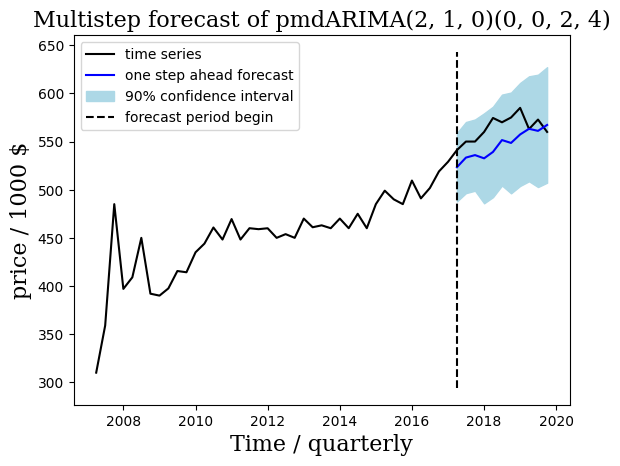

In [66]:
plot_time_series_forecast_with_error(df_ARIMA_mult_forecast.time_series, 
                                     df_ARIMA_mult_forecast.model_1, 
                                     df_ARIMA_mult_forecast.model_1_upper,
                                     df_ARIMA_mult_forecast.model_1_lower, 
                                     boundary,
                                     title='Multistep forecast of pmdARIMA(2, 1, 0)(0, 0, 2, 4)')

## Calculating one step ahead prediction of best mpdARIMA model

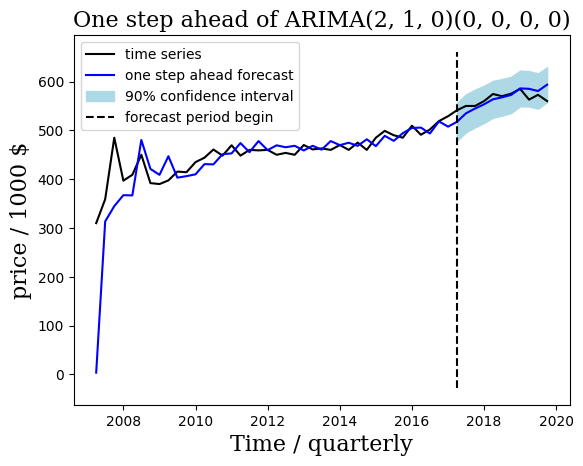

In [68]:
# model_1 proved to be unstable while calculating one step ahead forecasts. It was switched back to non-
# seasonal model_0.

# Define model and fit it on training data set
best_pmdARIMA = pm.ARIMA(order=(2, 1, 0), seasonal_order=(0, 0, 0, 0)).fit(df_train.three)

# Oredict on training data set
result_one_step_ahead = best_pmdARIMA.predict_in_sample()
# Predict one step ahead with confidence intervals returned
mean, conf_int = best_pmdARIMA.predict(1, return_conf_int=True, alpha=0.1)

# Initialize containers to collect each one step ahead prediction (for confidence intervals as well)
result_one_step_ahead = pd.concat([result_one_step_ahead, mean])
upper_list = [conf_int[0, 1]]
lower_list = [conf_int[0, 0]]

# iterate over remaining length of test data set
for i in range(1, len(df_test)):
    #in every iteration: reinitiate model and train it on prolonged training data set
    model = pm.ARIMA(order=(2, 1, 0), seasonal_order=(0, 0, 0, 0)).fit(df.iloc[:(boundary+i)].three)
    # predict one step ahead with confidence intervals
    mean, conf_int = model.predict(1, return_conf_int=True, alpha=0.1)
    # store reults 
    result_one_step_ahead = pd.concat([result_one_step_ahead, mean])
    upper_list.append(conf_int[0, 1])
    lower_list.append(conf_int[0, 0])

# Write results to new created DataFrame
df_ARIMA_one_step = pd.DataFrame(result_one_step_ahead, columns=['prediction']).assign(
                                 upper=pd.Series(upper_list, index=df.iloc[-(len(df)-boundary):].index), 
                                 lower=pd.Series(lower_list, index=df.iloc[-(len(df)-boundary):].index))

# Plot results of prediction
plot_time_series_forecast_with_error(df.three, df_ARIMA_one_step.prediction, 
                                     df_ARIMA_one_step.upper, df_ARIMA_one_step.lower,
                                     bound=boundary, title='One step ahead of ARIMA(2, 1, 0)(0, 0, 0, 0)', 
                                     alpha=0.9)

Convergence of ARIMA model on this problem is somehow problematic, when seasonalality is taken into account. Therefore it was switched back to nonseasonal model_0. This model obtained best AICc on training data set. Convergence is stable for this model.

In [36]:
# Calculation or rms of one step ahead prediction
print(f'rms of one step ahead ARIMA(2, 1, 0)(0, 0, 0, 0) \
is: {rms(df_test.three, df_ARIMA_one_step[boundary:].prediction):.1f}')

rms of one step ahead ARIMA(2, 1, 0)(0, 0, 0, 0) is: 15.6


# 3. Model: ETS-model

For ETS-model selection seasonality is excluded, as it was proven to be weak from previous models and by STL-decomposition. A trend is considered to be additive or damped additive. The error might be additive or multiplicative. This results in four models, which will be selected from their perofrmance measured by AICc on training data set. Models:
ETS(A, A, N)
ETS(Ad, A, N)
ETS(A, M, N)
ETS(Ad, M, N)

In [43]:
ets_A_A_N = ETSModel(endog=df_train.three, error='add', trend='add',
                     damped_trend=False, seasonal=None).fit()

ets_Ad_A_N = ETSModel(endog=df_train.three, error='add', trend='add',
                     damped_trend=True, seasonal=None).fit()

ets_A_M_N = ETSModel(endog=df_train.three, error='mul', trend='add',
                     damped_trend=False, seasonal=None).fit()

ets_Ad_M_N = ETSModel(endog=df_train.three, error='mul', trend='add',
                     damped_trend=True, seasonal=None).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.70422D+00    |proj g|=  4.26595D-01

At iterate    1    f=  4.69914D+00    |proj g|=  1.17817D-01

At iterate    2    f=  4.69324D+00    |proj g|=  7.98648D-02

At iterate    3    f=  4.68847D+00    |proj g|=  4.46351D-02

At iterate    4    f=  4.68784D+00    |proj g|=  4.91016D-02

At iterate    5    f=  4.68731D+00    |proj g|=  1.99186D-02

At iterate    6    f=  4.68709D+00    |proj g|=  1.96692D-02

At iterate    7    f=  4.68638D+00    |proj g|=  3.78172D-02

At iterate    8    f=  4.68579D+00    |proj g|=  1.14458D-01

At iterate    9    f=  4.68480D+00    |proj g|=  9.59835D-02

At iterate   10    f=  4.68059D+00    |proj g|=  2.84110D-02

At iterate   11    f=  4.65600D+00    |proj g|=  6.78231D-03

At iterate   12    f=  4.65599D+00    |proj g|=  1.09518D-02

At iterate   13    f=  4.6

In [47]:
print(f'AICc of ETS(A, A, N):\t{ets_A_A_N.aicc:.0f}')
print(f'AICc of ETS(Ad, A, N):\t{ets_Ad_A_N.aicc:.0f}')
print(f'AICc of ETS(A, M, N):\t{ets_A_M_N.aicc:.0f}')
print(f'AICc of ETS(Ad, M, N):\t{ets_Ad_M_N.aicc:.0f}')

AICc of ETS(A, A, N):	384
AICc of ETS(Ad, A, N):	383
AICc of ETS(A, M, N):	389
AICc of ETS(Ad, M, N):	391


From the results mode ETS(Ad, A, N) ist selected for forecasting.

In [88]:
ets_Ad_A_N.get_prediction(start=boundary, end=boundary+11).predicted_mean

2017-03-31 23:59:59.999999999    503.942265
2017-06-30 23:59:59.999999999    505.572085
2017-09-30 23:59:59.999999999    507.155884
2017-12-31 23:59:59.999999999    508.694962
2018-03-31 23:59:59.999999999    510.190582
2018-06-30 23:59:59.999999999    511.643971
2018-09-30 23:59:59.999999999    513.056322
2018-12-31 23:59:59.999999999    514.428792
2019-03-31 23:59:59.999999999    515.762509
2019-06-30 23:59:59.999999999    517.058567
2019-09-30 23:59:59.999999999    518.318028
2019-12-31 23:59:59.999999999    519.541926
Freq: Q-DEC, dtype: float64

In [87]:
ets_Ad_A_N.predict(start=41, end=51)

2017-06-30 23:59:59.999999999    505.572085
2017-09-30 23:59:59.999999999    507.155884
2017-12-31 23:59:59.999999999    508.694962
2018-03-31 23:59:59.999999999    510.190582
2018-06-30 23:59:59.999999999    511.643971
2018-09-30 23:59:59.999999999    513.056322
2018-12-31 23:59:59.999999999    514.428792
2019-03-31 23:59:59.999999999    515.762509
2019-06-30 23:59:59.999999999    517.058567
2019-09-30 23:59:59.999999999    518.318028
2019-12-31 23:59:59.999999999    519.541926
Freq: Q-DEC, dtype: float64